In [77]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from loader import load
from reduce import autoencode, pca, lda, cluster_reduce
from preprocess import default_preprocess
from process import LGBM, RForest, MLP
from sklearn.model_selection import train_test_split

PREPROCESSORS = {
    'default': default_preprocess,
    'none': lambda X: X,
}

DIM_REDUCTIONS = {
    'lda': lda,
    'pca': lambda X, _: pca(X, n_components=0.95),                              # n_components is set arbitrarily for now
    'autoencoder': lambda X, _: autoencode(X, n_components=53, save=True),      # n_components is set arbitrarily for now, the 53 here is what PCA usually chooses at 95%
    'hcluster': lambda X, _: cluster_reduce(X, n_components=53, linkage='ward')
}

PROCESSORS = {
    'lgbm': LGBM,
    'randomforest': RForest,
    'mlp': MLP,
}

In [45]:
def get_predictions(X, Y, test_size, dim_reduce_methods, classifiers):
    results = {}

    for classifier_name, classifier in classifiers.items():
        print(f"[PROCESS] Running {classifier_name}")
        classifier_results = []
        
        for dr_name, dr_method in dim_reduce_methods.items():
            print(f"[DIM REDUCE] Applying {dr_name}")
            X_reduced = dr_method(X, Y)
            
            auc, y_pred = classifier(X_reduced, Y, test_size=test_size)
            classifier_results.append((dr_name, auc, y_pred))
        
        results[classifier_name] = classifier_results

    return results

In [88]:
X, Y = load()
test_size = 0.2

X = default_preprocess(X)
results = get_predictions(X, Y, test_size, DIM_REDUCTIONS, PROCESSORS)

[LOADER] Loading training data
[PREPROCESS] Filling missing data
[PREPROCESS] Done filling missing data
[PREPROCESS] Label encoding categorical features
[PREPROCESS] Done label encoding categorical features
[PREPROCESS] Standardizing features
[PREPROCESS] Done standardizing features
[PROCESS] Running lgbm
[DIM REDUCE] Applying lda
[REDUCE] Starting LDA
[REDUCE] LDA reduced dimensionality to 1
[TEST] Testing LGBM
[LightGBM] [Info] Number of positive: 399833, number of negative: 400167
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499791 -> initscore=-0.000835
[LightGBM] [Info] Start training from score -0.000835


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[DIM REDUCE] Applying pca
[REDUCE] Starting PCA
[REDUCE] PCA reduced dimensionality to 53
[TEST] Testing LGBM


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 399833, number of negative: 400167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13515
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499791 -> initscore=-0.000835
[LightGBM] [Info] Start training from score -0.000835


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[DIM REDUCE] Applying autoencoder
[AUTOENCODER] Using loaded weights


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


31250/31250 ━━━━━━━━━━━━━━━━━━━━ 12s 385us/step
[TEST] Testing LGBM


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 399833, number of negative: 400167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13515
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499791 -> initscore=-0.000835
[LightGBM] [Info] Start training from score -0.000835


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[DIM REDUCE] Applying hcluster
[REDUCE] Starting Agglomerative Hierarchical Clustering
[REDUCE] Agglomerative clustering grouped features into 53 clusters
[REDUCE] Clustering reduced dimensionality to 53
[TEST] Testing LGBM


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 399833, number of negative: 400167
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4574
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499791 -> initscore=-0.000835
[LightGBM] [Info] Start training from score -0.000835


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[PROCESS] Running randomforest
[DIM REDUCE] Applying lda
[REDUCE] Starting LDA
[REDUCE] LDA reduced dimensionality to 1
[TEST] Testing Random Forest
[DIM REDUCE] Applying pca
[REDUCE] Starting PCA
[REDUCE] PCA reduced dimensionality to 53
[TEST] Testing Random Forest
[DIM REDUCE] Applying autoencoder
[AUTOENCODER] Using loaded weights


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


31250/31250 ━━━━━━━━━━━━━━━━━━━━ 11s 365us/step
[TEST] Testing Random Forest
[DIM REDUCE] Applying hcluster
[REDUCE] Starting Agglomerative Hierarchical Clustering
[REDUCE] Agglomerative clustering grouped features into 53 clusters
[REDUCE] Clustering reduced dimensionality to 53
[TEST] Testing Random Forest
[PROCESS] Running mlp
[DIM REDUCE] Applying lda
[REDUCE] Starting LDA
[REDUCE] LDA reduced dimensionality to 1
[TEST] Testing MLP
[DIM REDUCE] Applying pca
[REDUCE] Starting PCA
[REDUCE] PCA reduced dimensionality to 53
[TEST] Testing MLP
[DIM REDUCE] Applying autoencoder
[AUTOENCODER] Using loaded weights


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


31250/31250 ━━━━━━━━━━━━━━━━━━━━ 12s 370us/step
[TEST] Testing MLP
[DIM REDUCE] Applying hcluster
[REDUCE] Starting Agglomerative Hierarchical Clustering
[REDUCE] Agglomerative clustering grouped features into 53 clusters
[REDUCE] Clustering reduced dimensionality to 53
[TEST] Testing MLP


In [89]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size, random_state=42)

from sklearn.metrics import roc_auc_score
def fusion(prob_predictions, y, weights=None, **kwargs):
    prob_predictions = np.array(prob_predictions)

    if weights is None:
        weights = [1] * len(prob_predictions)  
    
    if (sum(weights) == 0):
        weight_sum = 1
    else:
        weight_sum = sum(weights)
    weights = np.array(weights) / weight_sum  # normalize weights
    fused_probs = np.average(prob_predictions, axis=0, weights=weights)

    auc_fused = roc_auc_score(y, fused_probs)
    print(f"[FUSION] AUC after fusion: {auc_fused:.4f}")
    return auc_fused, fused_probs

In [ ]:
def plot_confusion_matrix(true, pred, title="Confusion Matrix"):
    pred_labels = (pred >= 0.5).astype(int)
    cm = confusion_matrix(true, pred_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [92]:
for model, res in results.items():
    for dr, auc, pred in res:
        print(f"{model}-{dr} AUC: {auc}")

lgbm-lda AUC: 0.6700287851511515
lgbm-pca AUC: 0.6768909838256394
lgbm-autoencoder AUC: 0.6786765049470602
lgbm-hcluster AUC: 0.7094315327272613
randomforest-lda AUC: 0.5828349027133961
randomforest-pca AUC: 0.6705502789720111
randomforest-autoencoder AUC: 0.673494677789787
randomforest-hcluster AUC: 0.7017148963685959
mlp-lda AUC: 0.6701637416565497
mlp-pca AUC: 0.6954346702673867
mlp-autoencoder AUC: 0.6937181850487273
mlp-hcluster AUC: 0.6950741841529673


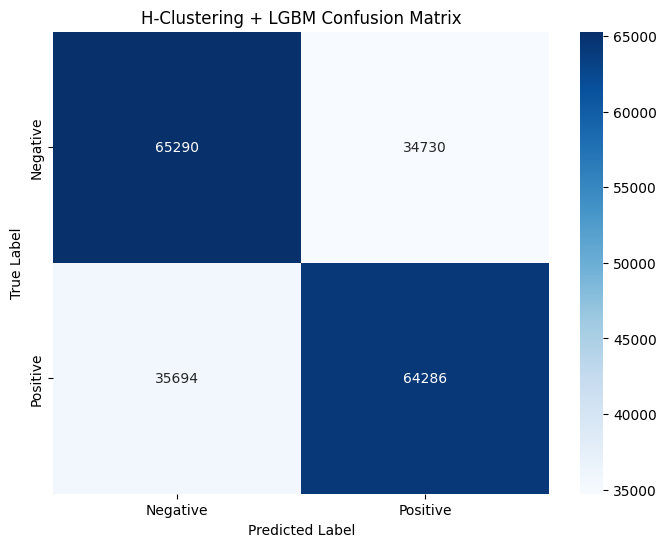

In [96]:
best_pred = results["lgbm"][3][2]
plot_confusion_matrix(y_val, best_pred, f"H-Clustering + LGBM Confusion Matrix")


[FUSION] Fusing predictions for DR method: lda
[FUSION] AUC after fusion: 0.6368
AUCs before Fusion: [0.6700287851511515, 0.5828349099633964, 0.6701637416565497]
Fused AUC for lda: 0.6368


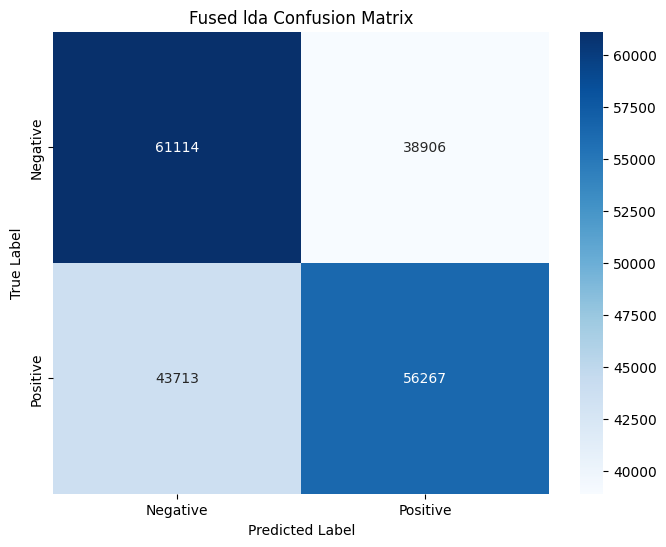


[FUSION] Fusing predictions for DR method: pca
[FUSION] AUC after fusion: 0.6924
AUCs before Fusion: [0.6768909838256394, 0.6705502789720111, 0.6954346702673867]
Fused AUC for pca: 0.6924


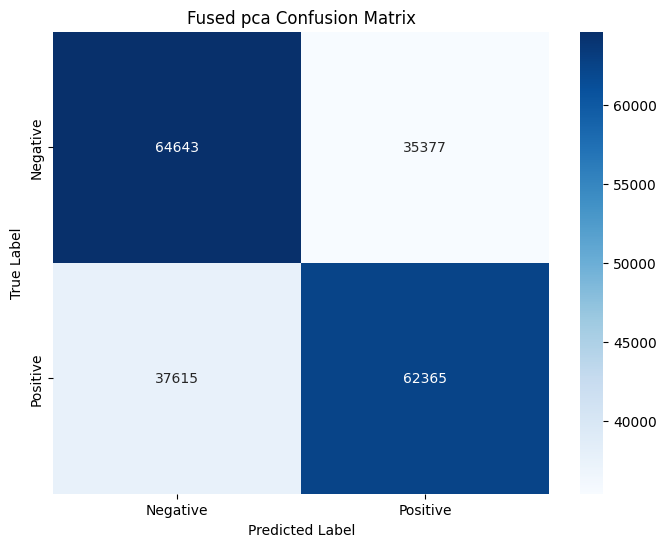


[FUSION] Fusing predictions for DR method: autoencoder
[FUSION] AUC after fusion: 0.6924
AUCs before Fusion: [0.6786765049470602, 0.6734946776897871, 0.6937181850487273]
Fused AUC for autoencoder: 0.6924


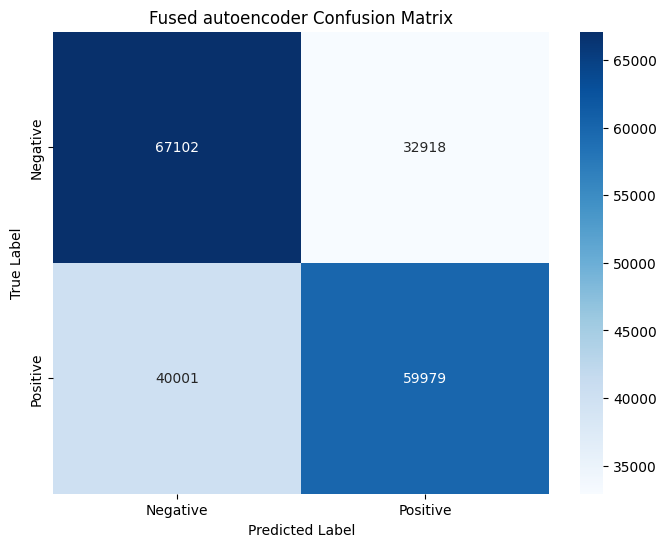


[FUSION] Fusing predictions for DR method: hcluster
[FUSION] AUC after fusion: 0.7109
AUCs before Fusion: [0.7094315327272613, 0.7017148964685959, 0.6950741841529673]
Fused AUC for hcluster: 0.7109


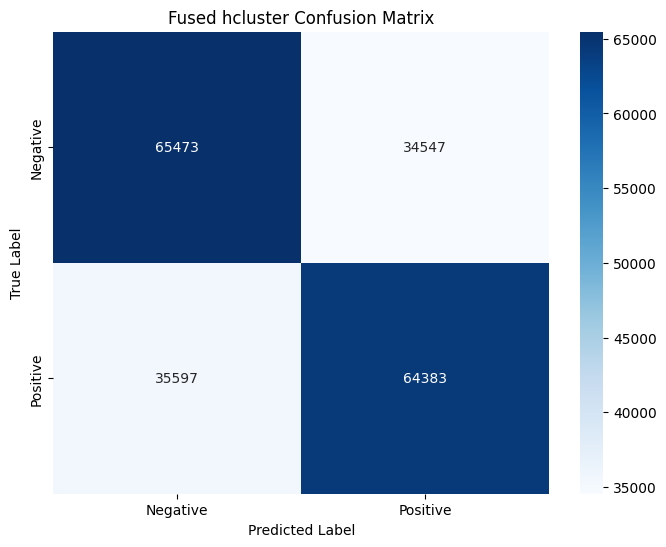

In [78]:
# Fusing different classifiers, same DR
for dr_name in DIM_REDUCTIONS.keys():
    print(f"\n[FUSION] Fusing predictions for DR method: {dr_name}")
    prob_predictions = []
    auc_arr = []
    for classifier_results in results.values():
        for dr, auc, res in classifier_results:
            if dr == dr_name:
                prob_predictions.append(res)
                auc_arr.append(float(auc))


    auc_fused, fused_probs = fusion(prob_predictions, y_val)
    print(f"AUCs before Fusion: {auc_arr}")
    print(f"Fused AUC for {dr_name}: {auc_fused:.4f}")

    plot_confusion_matrix(y_val, fused_probs, f"Fused {dr_name} Confusion Matrix")

In [26]:
original_results = []

for classifier_name, classifier in PROCESSORS.items():
    print(f"[PROCESS] Running {classifier_name} without DR")

    auc, y_pred = classifier(X, Y, test_size=test_size)
    original_results.append((classifier_name, auc, y_pred))

[PROCESS] Running lgbm without DR
[TEST] Testing LGBM


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 399833, number of negative: 400167
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5214
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499791 -> initscore=-0.000835
[LightGBM] [Info] Start training from score -0.000835


c:\Users\Jonathan\CS\cs522\522Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[PROCESS] Running randomforest without DR
[TEST] Testing Random Forest
[PROCESS] Running mlp without DR
[TEST] Testing MLP


lgbm: 0.7135


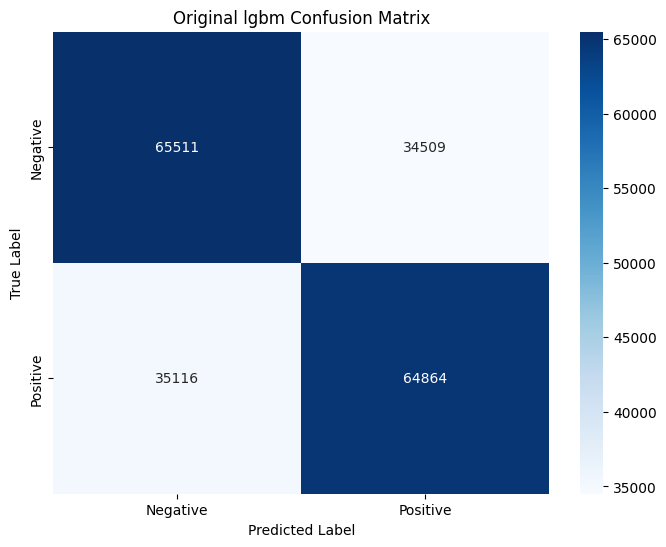

randomforest: 0.7030


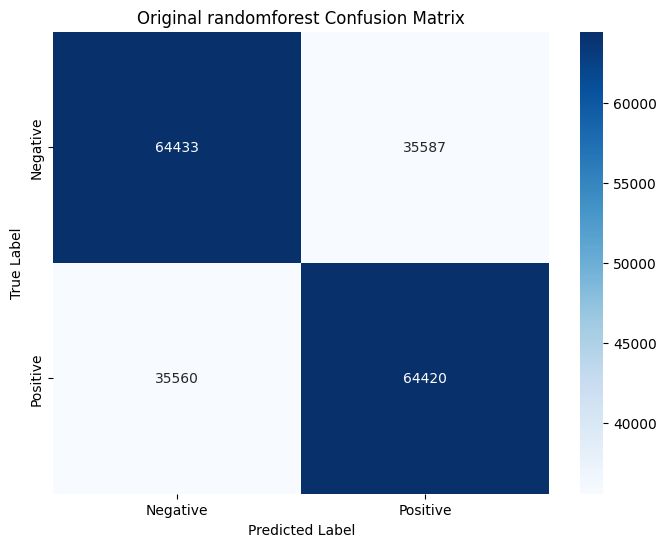

mlp: 0.7002


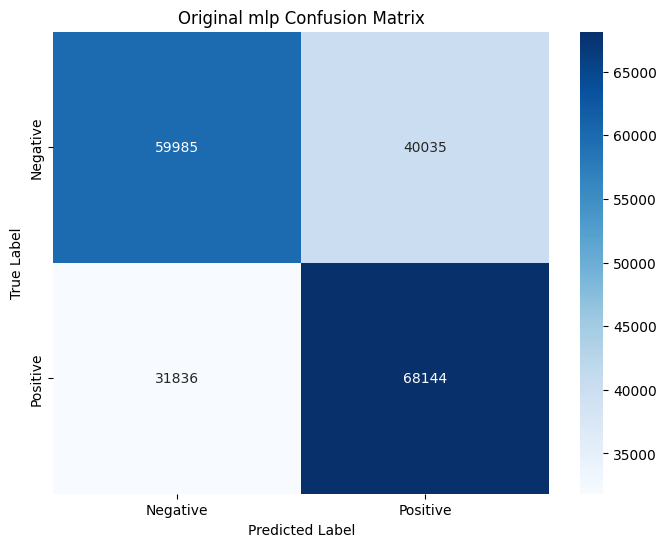

In [80]:
orig_predictions = []
for model, auc, pred in original_results:
    print(f"{model}: {auc:.4f}")
    orig_predictions.append(pred)

    plot_confusion_matrix(y_val, pred, f"Original {model} Confusion Matrix")



[FUSION] AUC after fusion: 0.7150
Fused Original AUC: 0.7150


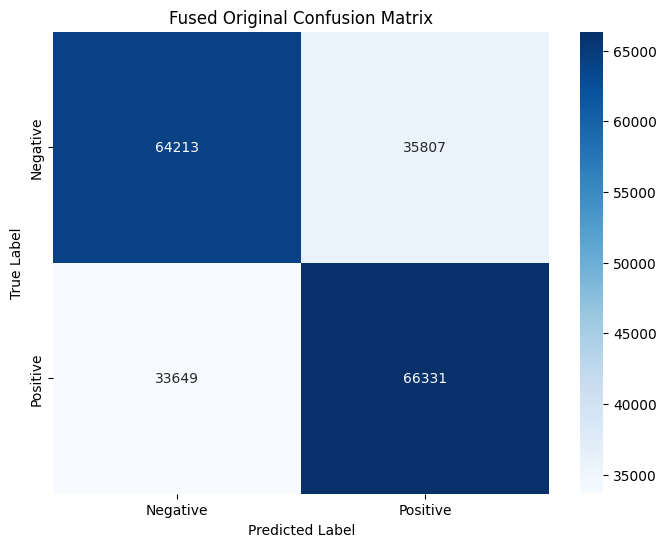

In [81]:
fused_orig_auc, fused_probs = fusion(orig_predictions, y_val)
print(f"Fused Original AUC: {fused_orig_auc:.4f}")

plot_confusion_matrix(y_val, fused_probs, f"Fused Original Confusion Matrix")
